## Data Selection and Cleaning

In [3]:
import pandas as pd
df=pd.read_csv("/Users/zhuziyu/Desktop/NYSERDA_Electric_Vehicle_Drive_Clean_Rebate_Data__Beginning_2017_20240801.csv")
df

,Data through Date,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,05/31/2024,05/28/2020,Tesla,Model Y,NaN,10509.0,BEV,Purchase,3.018,592.890,2000
1,05/31/2024,08/30/2023,Chevrolet,Bolt,NaN,NaN,BEV,Purchase,3.018,592.890,2000
2,05/31/2024,11/08/2023,Jeep,Grand Cherokee,NaN,13647.0,PHEV,Lease,0.089,247.229,500
3,05/31/2024,04/04/2024,Toyota,Prius Prime,NaN,12922.0,PHEV,Purchase,2.955,440.109,500
4,05/31/2024,05/02/2024,Volvo,XC60 T8,NaN,13617.0,PHEV,Lease,0.411,200.580,500
...,...,...,...,...,...,...,...,...,...,...,...
154575,05/31/2024,04/01/2024,Toyota,Prius Prime,Yates,14527.0,PHEV,Purchase,2.955,440.109,500
154576,05/31/2024,04/22/2024,Toyota,RAV4 Prime,Yates,14527.0,PHEV,Lease,2.198,470.519,500
154577,05/31/2024,04/29/2024,Tesla,Model Y,Yates,14527.0,BEV,Lease,3.018,592.890,500
154578,05/31/2024,05/01/2024,Volvo,XC60 T8,Yates,14478.0,PHEV,Lease,0.411,200.580,500


In [5]:
check_missing_value = df.isna().sum()
print(check_missing_value)
print(df.dtypes)

Data through Date                            0
Submitted Date                               0
Make                                         0
Model                                        2
County                                       5
ZIP                                          1
EV Type                                      0
Transaction Type                             4
Annual GHG Emissions Reductions (MT CO2e)    0
Annual Petroleum Reductions (gallons)        0
Rebate Amount (USD)                          0
dtype: int64
Data through Date                             object
Submitted Date                                object
Make                                          object
Model                                         object
County                                        object
ZIP                                          float64
EV Type                                       object
Transaction Type                              object
Annual GHG Emissions Reductions (MT CO2e)    f

In [7]:
#Missing value
df['Model'].fillna(df['Model'].mode()[0], inplace=True)
df.dropna(subset=['County'], inplace=True)
df.dropna(subset=['ZIP'], inplace=True)

transaction_type_mode = df['Transaction Type'].mode()[0]
df['Transaction Type'].fillna(transaction_type_mode, inplace=True)

print(df.isnull().sum())

Data through Date                            0
Submitted Date                               0
Make                                         0
Model                                        0
County                                       0
ZIP                                          0
EV Type                                      0
Transaction Type                             0
Annual GHG Emissions Reductions (MT CO2e)    0
Annual Petroleum Reductions (gallons)        0
Rebate Amount (USD)                          0
dtype: int64


In [9]:
df['Submitted Date'] = pd.to_datetime(df['Submitted Date'])
df['Year'] = df['Submitted Date'].dt.year
df = df[df['Year'] != 2024]

In [11]:
#Feature Selection

In [15]:
df.loc[:, 'Submitted Date'] = pd.to_datetime(df['Submitted Date'])
df.loc[:, 'Year'] = df['Submitted Date'].dt.year
df.loc[:, 'Quarter'] = df['Submitted Date'].dt.quarter

In [19]:
cumulative_ghg = df.groupby('Year')['Annual GHG Emissions Reductions (MT CO2e)'].sum().cumsum()
cumulative_petroleum = df.groupby('Year')['Annual Petroleum Reductions (gallons)'].sum().cumsum()
df.loc[:, 'Cumulative GHG Reductions'] = df['Year'].map(cumulative_ghg)
df.loc[:, 'Cumulative Petroleum Reductions'] = df['Year'].map(cumulative_petroleum)

In [23]:
df.loc[:, 'Avg GHG Reduction per Vehicle'] = df['Annual GHG Emissions Reductions (MT CO2e)'] / df.groupby('Year')['Make'].transform('count')
df.loc[:, 'Avg Petroleum Reduction per Vehicle'] = df['Annual Petroleum Reductions (gallons)'].groupby(df['Year']).transform('sum') / df.groupby('Year')['Make'].transform('count')

In [27]:
market_acceptance = df.groupby('Year')['Make'].count()
df.loc[:, 'Market Acceptance'] = df['Year'].map(market_acceptance)

In [31]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

categorical_cols = ['EV Type', 'Transaction Type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[categorical_cols])

numeric_features = df[['Year', 'Quarter', 'Annual GHG Emissions Reductions (MT CO2e)', 
                         'Annual Petroleum Reductions (gallons)', 'Rebate Amount (USD)', 
                         'Cumulative GHG Reductions', 'Cumulative Petroleum Reductions', 
                         'Avg GHG Reduction per Vehicle', 'Avg Petroleum Reduction per Vehicle', 
                         'Market Acceptance']].values

all_features = np.hstack([numeric_features, encoded_features])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(all_features)

print(f"Selected features shape: {selected_features.shape}")

Selected features shape: (135133, 11)


## Research Question 1

### Q1. How has the annual treand in EV registrations (both BEV and PHEV) evolved from 2017 to 2023?

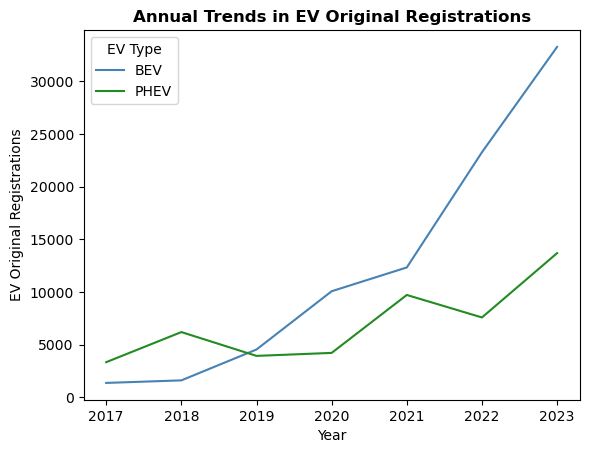

In [33]:
import matplotlib.pyplot as plt

df = df.dropna(subset=['Year', 'EV Type'])

# Group by Year and EV Type, and count the registrations
registration_counts = df.groupby(['Year', 'EV Type']).size().unstack(fill_value=0)

# Plot stacked bar chart
ax = registration_counts.plot(kind='line', stacked=False, color=['steelblue', 'forestgreen'])

# Set title 
plt.title('Annual Trends in EV Original Registrations', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('EV Original Registrations')
plt.legend(title='EV Type', labels=['BEV', 'PHEV'])

plt.show()

This graph illustrates the annual trends in original registrations for two types of electric vehicles (EVs)—Battery Electric Vehicles (BEV) and Plug-in Hybrid Electric Vehicles (PHEV)—from 2017 to 2023.

Key Points:
BEV Registrations: There is a consistent and significant increase in BEV registrations each year, with a sharp rise starting around 2021 and continuing through 2023.
PHEV Registrations: PHEV registrations show a more fluctuating trend, with some growth in 2018, a dip in 2019, and then a gradual increase from 2020 onwards, particularly picking up pace after 2021.

Overall, the graph suggests a growing trend in the adoption of EVs, with BEVs showing a more pronounced and steady increase compared to PHEVs.

## Research Question 2

### Q2-1. What is the distribution of rebate amounts given out between 2017 and 2023 ?

Rebate Amount (USD)
500     71896
1000     8932
1100    15628
1700     6649
2000    32027
Name: count, dtype: int64


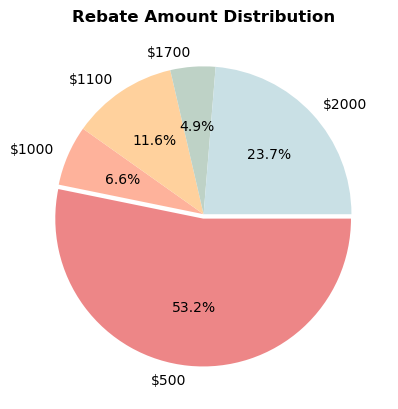

In [35]:
df_rebate = df[df['Rebate Amount (USD)'] != 0]

# Calculate the count of each rebate amount
rebate_distribution = df_rebate['Rebate Amount (USD)'].value_counts().sort_index()
print(rebate_distribution)

colors = ['#ed8687', '#feb29b', '#ffd19d', '#bed2c6', '#c9e0e5']
explode = (0.03, 0, 0, 0, 0)  

plt.pie(rebate_distribution, colors=colors, labels=[f'${int(label)}' for label in rebate_distribution.index],
        explode=explode, autopct='%1.1f%%', counterclock=False, shadow=False)

plt.title('Rebate Amount Distribution', fontweight='bold')

plt.show()

`$500` Rebate: The largest segment, accounting for 53.2% of the total rebates, indicating that over half of the rebates issued were at this amount.

`$2000` Rebate: The second-largest segment, representing 23.7% of the total rebates, shows a significant portion of the rebates were at the highest amount.

The majority of rebates were issued at the lower `$500` level, with a substantial portion also at the highest `$2000` level, while the middle-tier rebate amounts were less common.

### Q2-2. How do the EVs in different rebate levels impact the reduction in GHG emissions and petroleum consumption?

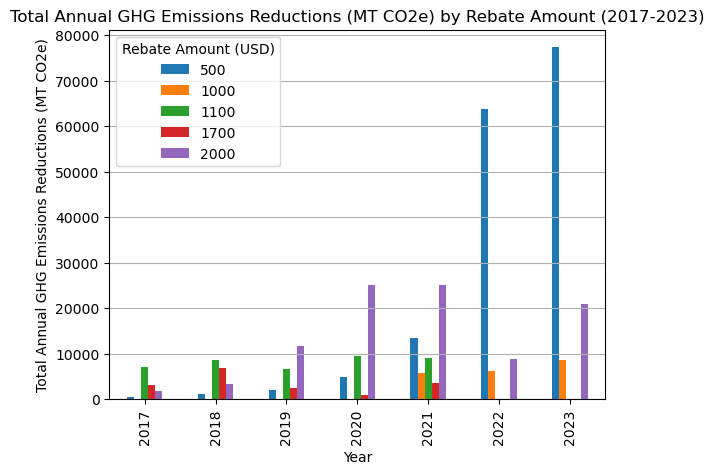

In [50]:
columns_of_interest_AGR = ['Year', 'Rebate Amount (USD)', 'Annual GHG Emissions Reductions (MT CO2e)']
df_AGR = df[columns_of_interest_AGR]

df_AGR = df_AGR.dropna()

rebate_amounts = [2000, 1700, 1100, 1000, 500]
filtered_df_AGR = df_AGR[df_AGR['Rebate Amount (USD)'].isin(rebate_amounts)]

ghg_sums = filtered_df_AGR.groupby(['Year', 'Rebate Amount (USD)'])['Annual GHG Emissions Reductions (MT CO2e)'].sum().unstack().fillna(0)

bar_AGR = ghg_sums.plot(kind='bar')
plt.title('Total Annual GHG Emissions Reductions (MT CO2e) by Rebate Amount (2017-2023)')
plt.xlabel('Year')
plt.ylabel('Total Annual GHG Emissions Reductions (MT CO2e)')
plt.legend(title='Rebate Amount (USD)')
plt.grid(axis='y')

plt.show()

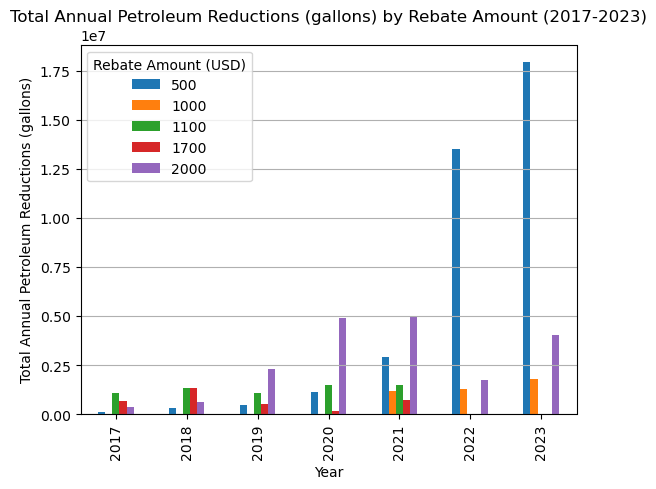

In [52]:
columns_of_interest_APR = ['Year', 'Rebate Amount (USD)', 'Annual Petroleum Reductions (gallons)']
df_APR = df[columns_of_interest_APR]


df_APR = df_APR.dropna()

filtered_df_APR = df_APR[df_APR['Rebate Amount (USD)'].isin(rebate_amounts)]

petroleum_sums = filtered_df_APR.groupby(['Year', 'Rebate Amount (USD)'])['Annual Petroleum Reductions (gallons)'].sum().unstack().fillna(0)

bar_APR = petroleum_sums.plot(kind='bar')
plt.title('Total Annual Petroleum Reductions (gallons) by Rebate Amount (2017-2023)')
plt.xlabel('Year')
plt.ylabel('Total Annual Petroleum Reductions (gallons)')
plt.legend(title='Rebate Amount (USD)')
plt.grid(axis='y')

plt.show()

This graph provides several key insights:

Significant Contribution from EVs with the Lowest Rebate (`$500`):

The graph shows that in 2022 and 2023, EVs receiving the lowest rebate of `$500` contributed the most to GHG emissions reductions, far exceeding other higher rebate categories. This suggests that despite their likely lower per-vehicle emission reduction capability, their high volume in the market results in a substantial overall reduction.
Lower-than-Expected Impact from High-Rebate EVs:

Typically, higher rebate amounts are associated with vehicles that can reduce emissions more effectively on a per-vehicle basis. However, in this graph, EVs with the highest rebate of `$2000` have a smaller overall impact on emissions reduction compared to the `$500` rebate category in 2022 and 2023. This might indicate that while these vehicles are more advanced, they may have lower market penetration due to higher costs or other factors.
Impact of Market Acceptance and Rebate Design:

The data highlights the importance of market acceptance and rebate design. Vehicles in the `$500` rebate category may be more affordable and thus more popular among consumers, leading to higher sales volumes. Even though each vehicle might contribute less individually, their sheer numbers result in the largest total emissions reductions.

Summary:
This graph suggests that in the context of GHG emissions reductions, the total number of vehicles on the road (market acceptance) can be more critical than the per-vehicle reduction capability. While higher rebate EVs are expected to contribute more to emissions reductions, the reality reflected in the data shows that lower rebate EVs, due to their greater market penetration, have made the most significant overall impact. This finding is crucial for policymakers who need to consider not just the emissions reduction potential of individual vehicles but also strategies to maximize the adoption of EVs to achieve broader environmental benefits.

The reduction by petrol consumption follows the same pattern as GHG emissions.

### Q2-3. What is the relationship between subsidy amount and market acceptance for electric vehicles from 2017 to 2023?

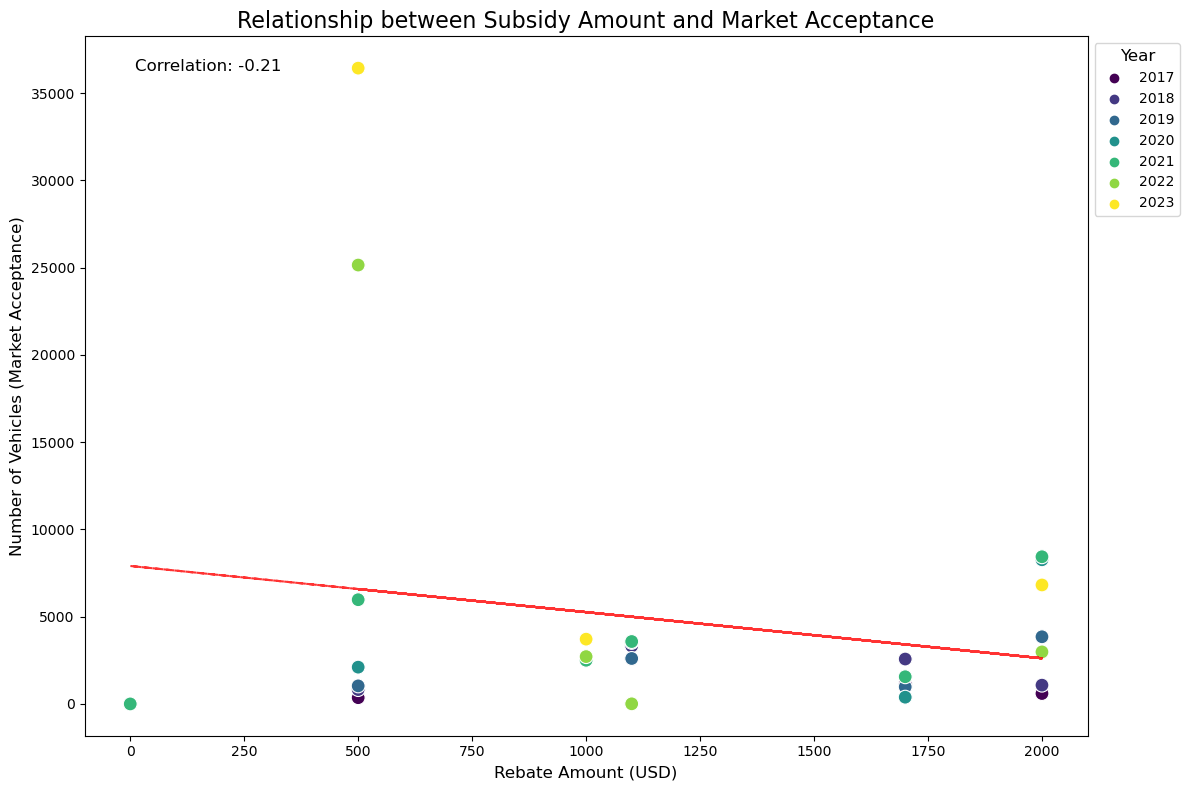

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by Year and Rebate Amount, then count the number of vehicles
market_acceptance = df.groupby(['Year', 'Rebate Amount (USD)'])['Make'].count().reset_index(name='Vehicle Count')

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=market_acceptance, x='Rebate Amount (USD)', y='Vehicle Count', hue='Year', palette='viridis', s=100)

# Add a trend line
x = market_acceptance['Rebate Amount (USD)']
y = market_acceptance['Vehicle Count']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.8)

# Customize the plot
plt.title('Relationship between Subsidy Amount and Market Acceptance', fontsize=16)
plt.xlabel('Rebate Amount (USD)', fontsize=12)
plt.ylabel('Number of Vehicles (Market Acceptance)', fontsize=12)

# Add annotations for correlation
correlation = np.corrcoef(x, y)[0, 1]
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

# Customize the legend
plt.legend(title='Year', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

The scatter plot shows a negative correlation of -0.21 between the rebate amount and the number of vehicles (market acceptance). This suggests that higher rebates are generally associated with lower market acceptance, as indicated by the decreasing number of vehicles as the rebate amount increases.

Market Acceptance Trend: Vehicles with lower rebate amounts (e.g., `$500`) tend to have much higher market acceptance, with some models achieving registrations of over 35,000 vehicles, particularly in the later years (2022 and 2023). Conversely, vehicles with higher rebates (`$1,000` to `$2,000`) have fewer registrations, which might indicate that while these vehicles have more substantial financial incentives, they may also be more expensive or less accessible to a broader market, limiting their overall adoption.


Implications: This trend suggests that while higher rebates are intended to incentivize the purchase of more expensive or advanced vehicles, they may not be as effective in driving widespread market acceptance compared to lower rebates, which apply to more affordable or widely available models. This finding could inform future subsidy strategies to balance cost and market impact.

## Research Question 3

### Q3. What are the top selling EV brands and models within the $500 rebate category?

          Make                    Model  Count
0        Tesla                  Model Y  27474
1        Tesla                  Model 3   8865
2         Jeep                 Wrangler   5801
3        Tesla                  Model X   4235
4        Tesla                  Model S   3147
5         Jeep           Grand Cherokee   2728
6       Toyota              Prius Prime   2293
7         Ford           Mustang Mach-E   1976
8      Hyundai  Hyundai Ioniq 5  77 kWh   1611
9          BMW                       X5   1179
10         Kia                  Kia EV6    729
11         BMW                     530e    691
12  Volkswagen                     ID.4    675
13     Hyundai                 Santa Fe    610
14       Volvo                  XC90 T8    584
15      Subaru           Crosstrek PHEV    528
16         BMW                   BMW I4    504
17       Volvo                  XC60 T8    492
18         BMW                   BMW iX    488
19     Hyundai                   Tucson    466


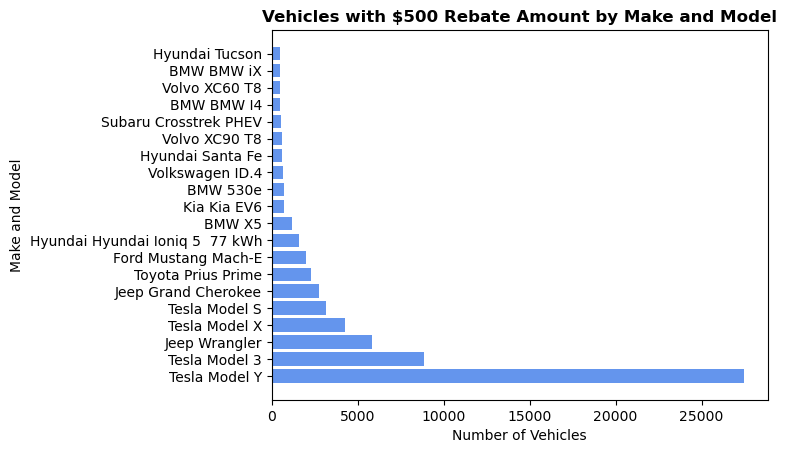

In [17]:
rebate_500_vehicles = df[df['Rebate Amount (USD)'] == 500]
rebate_500_counts = rebate_500_vehicles.groupby(['Make', 'Model']).size().reset_index(name='Count')
sorted_rebate_500_counts = rebate_500_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_vehicles_rebate_500 = sorted_rebate_500_counts.head(20)
print(top_vehicles_rebate_500)

bars = plt.barh(top_vehicles_rebate_500['Make'] + ' ' + top_vehicles_rebate_500['Model'], top_vehicles_rebate_500['Count'], color='cornflowerblue')

plt.title('Vehicles with $500 Rebate Amount by Make and Model', fontweight='bold')
plt.xlabel('Number of Vehicles')
plt.ylabel('Make and Model')

plt.show()

Tesla Dominance: Tesla is the clear leader within the `$500` rebate category, with the Tesla Model Y and Tesla Model 3 being the top two models. The Tesla Model Y is the most popular, with over 25,000 vehicles receiving the rebate, followed by the Tesla Model 3 with around 10,000 vehicles.

Other Popular Models: The Jeep Wrangler, Tesla Model X, and Tesla Model S also have a significant number of vehicles in this rebate category, though they are far behind the Model Y and Model 3 in terms of volume.

Limited Distribution Among Other Brands: Other models, such as the Hyundai Ioniq 5, Ford Mustang Mach-E, and Toyota Prius Prime, have much smaller numbers in this category, with fewer than 5,000 vehicles each receiving the `$500` rebate.

In [18]:
vehicle_counts = df.groupby(['Make', 'EV Type']).size().reset_index(name='Count')
sorted_vehicle_counts = vehicle_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

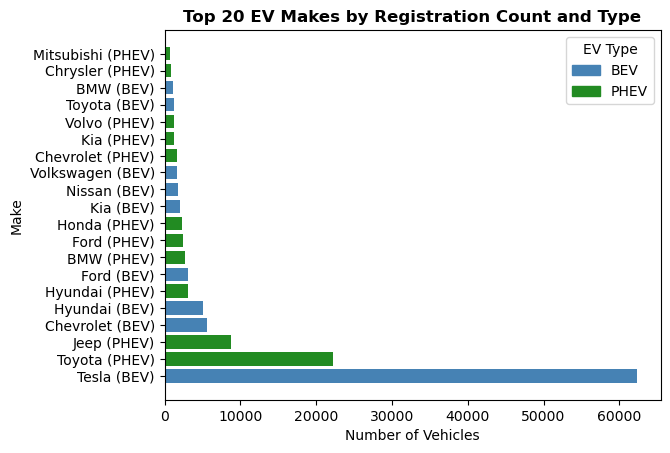

In [19]:
top_vehicles = sorted_vehicle_counts.head(20)

bev_color = 'steelblue' 
phev_color = 'forestgreen' 

colors = top_vehicles['EV Type'].map({'BEV': bev_color, 'PHEV': phev_color})

bars = plt.barh(top_vehicles['Make'] + ' (' + top_vehicles['EV Type'] + ')', top_vehicles['Count'], color=colors)

plt.title('Top 20 EV Makes by Registration Count and Type', fontweight='bold')
plt.xlabel('Number of Vehicles')
plt.ylabel('Make')
plt.legend(
    handles=[
        plt.Rectangle((0,0),1,1, color=bev_color, label='BEV'),
        plt.Rectangle((0,0),1,1, color=phev_color, label='PHEV')
    ],
    title='EV Type'
)

plt.show()

Tesla (BEV) Dominance:

Tesla, with its BEV models, has a significantly higher number of registrations compared to any other make, with more than 60,000 vehicles registered. This makes Tesla the leading EV brand by a wide margin.

Toyota's Dual Presence:

Toyota appears prominently in both the PHEV and BEV categories, with its PHEV registrations slightly outpacing its BEV registrations. This highlights Toyota's balanced approach to both electric vehicle types.

Other Brands:

Brands like Chevrolet, Hyundai, and Ford also have notable registrations in both BEV and PHEV categories, though they trail significantly behind Tesla.
Some brands, like BMW, Kia, and Volvo, show a stronger presence in the PHEV category compared to BEV.

### Q4-1. How have annual and comulative GHG emissions and petroleum reductions progressed from 2017 to 2023?

### Annual and Cumulative GHG emission reductions and petroleum reductions

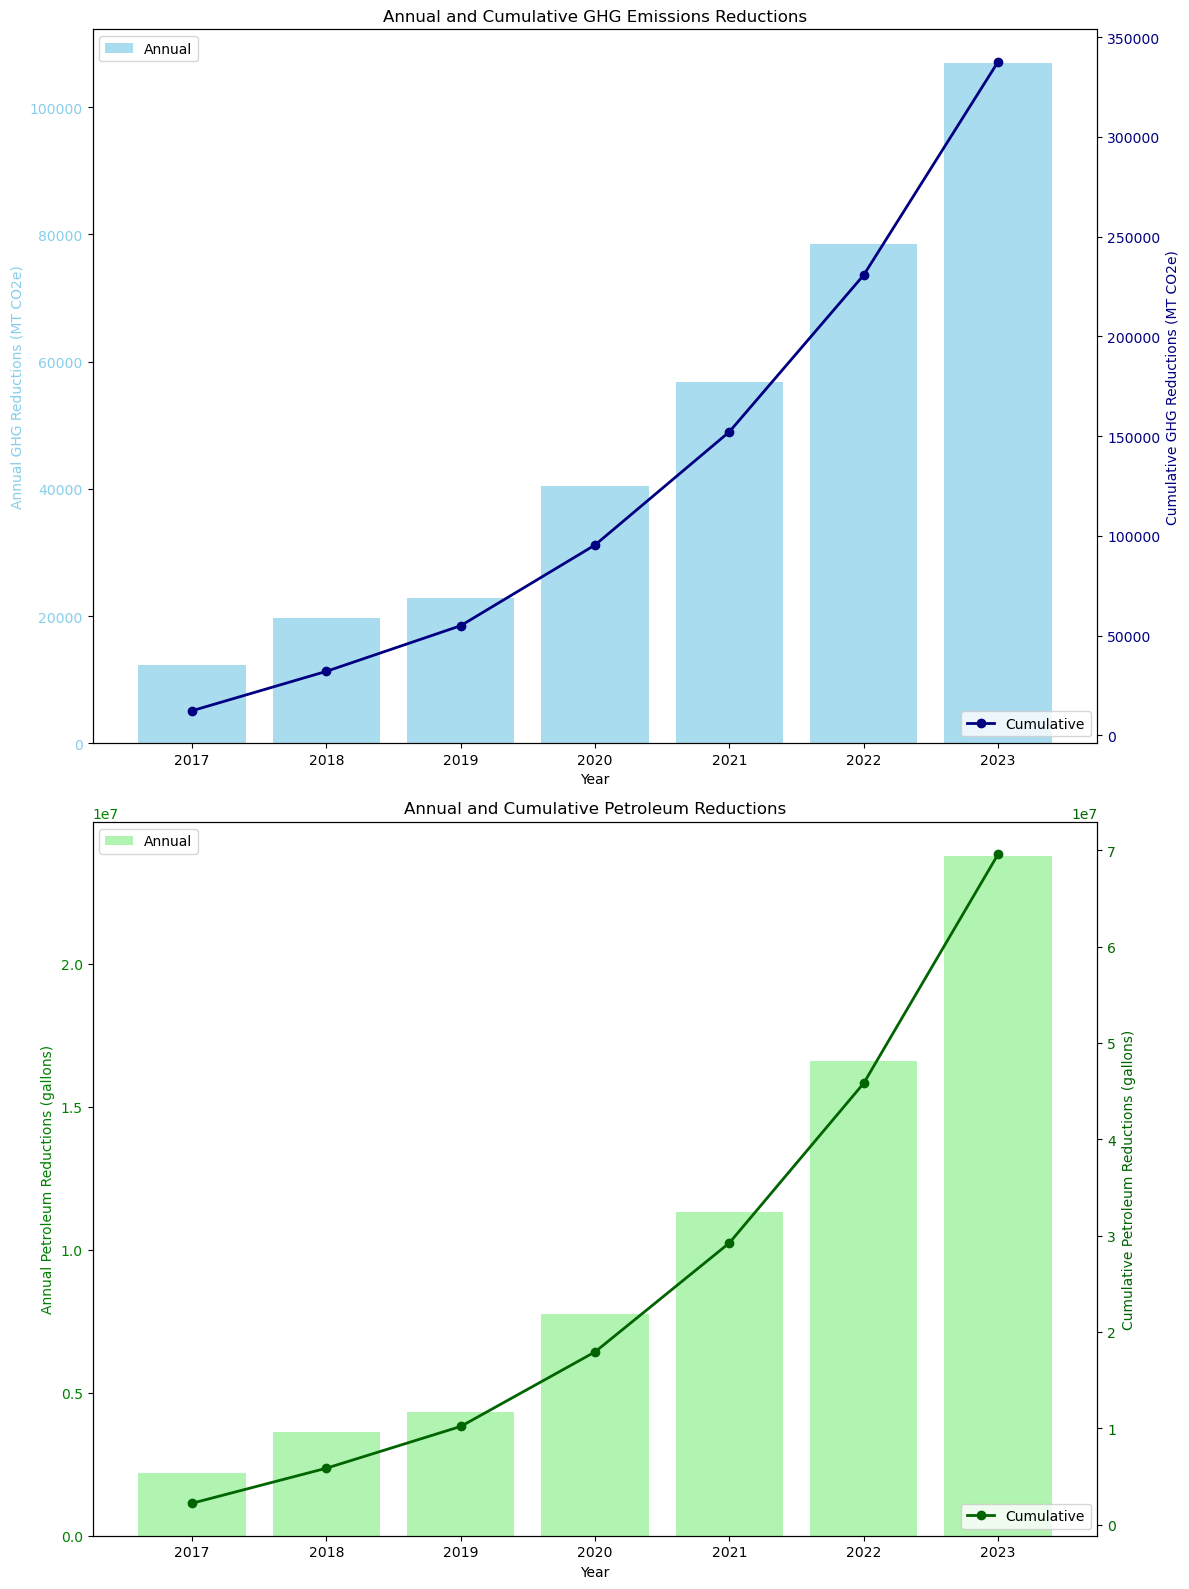

In [21]:
# Group by Year and sum the reductions
annual_reductions = df.groupby('Year').agg({
    'Annual GHG Emissions Reductions (MT CO2e)': 'sum',
    'Annual Petroleum Reductions (gallons)': 'sum'
})

# Calculate cumulative reductions
cumulative_reductions = annual_reductions.cumsum()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot GHG reductions
ax1.bar(annual_reductions.index, annual_reductions['Annual GHG Emissions Reductions (MT CO2e)'], 
        color='skyblue', alpha=0.7, label='Annual')
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual GHG Reductions (MT CO2e)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax1_twin = ax1.twinx()
ax1_twin.plot(cumulative_reductions.index, cumulative_reductions['Annual GHG Emissions Reductions (MT CO2e)'], 
              color='navy', linewidth=2, marker='o', label='Cumulative')
ax1_twin.set_ylabel('Cumulative GHG Reductions (MT CO2e)', color='navy')
ax1_twin.tick_params(axis='y', labelcolor='navy')

ax1.set_title('Annual and Cumulative GHG Emissions Reductions')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='lower right')

# Plot Petroleum reductions
ax2.bar(annual_reductions.index, annual_reductions['Annual Petroleum Reductions (gallons)'], 
        color='lightgreen', alpha=0.7, label='Annual')
ax2.set_xlabel('Year')
ax2.set_ylabel('Annual Petroleum Reductions (gallons)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax2_twin = ax2.twinx()
ax2_twin.plot(cumulative_reductions.index, cumulative_reductions['Annual Petroleum Reductions (gallons)'], 
              color='darkgreen', linewidth=2, marker='o', label='Cumulative')
ax2_twin.set_ylabel('Cumulative Petroleum Reductions (gallons)', color='darkgreen')
ax2_twin.tick_params(axis='y', labelcolor='darkgreen')

ax2.set_title('Annual and Cumulative Petroleum Reductions')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='lower right')

plt.tight_layout()
plt.show()

The charts demonstrate a clear and accelerating trend in both GHG emissions reductions and petroleum reductions over the period from 2017 to 2023.

Annual Reductions: Both GHG emissions (top chart) and petroleum use (bottom chart) have shown consistent growth year over year, with significant increases particularly after 2020. This indicates that the efforts to reduce emissions and petroleum consumption are becoming more effective over time.

Cumulative Impact: The cumulative reductions for both GHG emissions and petroleum (represented by the lines in the charts) have grown exponentially, highlighting the compounding effect of these annual improvements. By 2023, cumulative GHG reductions have exceeded 350,000 metric tons of CO2e, and cumulative petroleum reductions have surpassed 70 million gallons, showcasing the substantial long-term impact of these initiatives.

These trends suggest that the strategies employed to reduce emissions and petroleum consumption are not only working but are gaining momentum, leading to increasingly significant environmental benefits over time.

### Q4-2. What is the trend of average annual GHG emissions and petroleum reductions per vehicle from 2017 to 2023?

### Average Annual Emission Reduction and Petroleum Reduction Per Vehicle

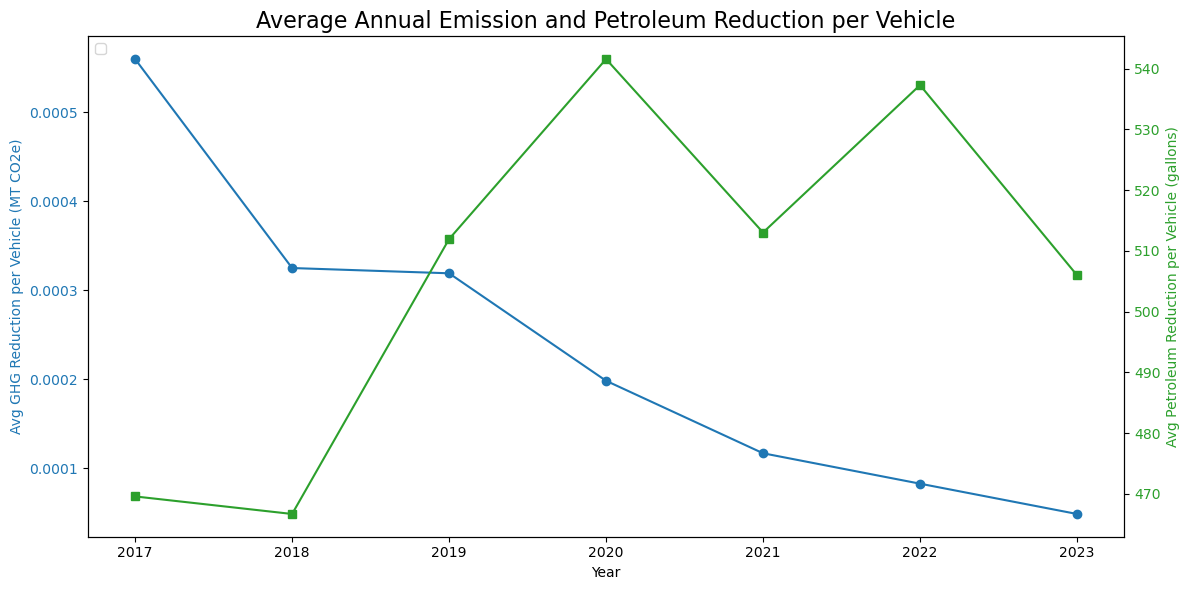

In [23]:
# Group by Year and calculate average reductions per vehicle
avg_reductions = df.groupby('Year').agg({
    'Avg GHG Reduction per Vehicle': 'mean',
    'Avg Petroleum Reduction per Vehicle': 'mean'
}).reset_index()

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average GHG reduction per vehicle
color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg GHG Reduction per Vehicle (MT CO2e)', color=color1)
ax1.plot(avg_reductions['Year'], avg_reductions['Avg GHG Reduction per Vehicle'], color=color1, marker='o')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Avg Petroleum Reduction per Vehicle (gallons)', color=color2)
ax2.plot(avg_reductions['Year'], avg_reductions['Avg Petroleum Reduction per Vehicle'], color=color2, marker='s')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legend
plt.title('Average Annual Emission and Petroleum Reduction per Vehicle', fontsize=16)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Avg GHG Reduction', 'Avg Petroleum Reduction'], loc='upper left')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The graph shows two distinct trends for average GHG emissions reduction per vehicle and average petroleum reduction per vehicle over time:

Average GHG Emissions Reduction per Vehicle:

There is a clear downward trend in average GHG emissions reduction per vehicle from 2017 to 2023. This suggests that while the total number of vehicles might be increasing, the efficiency in terms of GHG reductions per vehicle is decreasing. This could be due to an increase in the adoption of less efficient models or a wider range of vehicle types being included over time.

Average Petroleum Reduction per Vehicle:

The average petroleum reduction per vehicle fluctuates over the years, with peaks in 2020 and 2022. Despite some variability, it generally shows a higher level compared to earlier years, indicating that the average vehicle is becoming more effective in reducing petroleum use, especially after 2018.
These trends indicate a complex relationship where overall gains in petroleum reduction might not always align with reductions in GHG emissions on a per-vehicle basis, possibly due to variations in vehicle types and technologies being adopted.

## Conclusion

Market Acceptance vs. Rebate Amount: Lower rebate amounts, particularly `$500`, are associated with higher market acceptance. Higher rebates, while potentially targeting more advanced or expensive models, did not achieve the same level of market penetration.

Environmental Impact: Despite the lower per-vehicle rebate amount, vehicles with the `$500` rebate contribute significantly to total GHG emissions and petroleum reductions due to their high volume of registrations. However, the average reduction per vehicle has decreased over time, indicating that while more vehicles are on the road, they may not be as efficient individually.

## Recommendation

Reevaluate Rebate Strategy: Consider revising the rebate structure to balance the incentive amounts with market adoption goals. While high rebates should continue to support the purchase of advanced EVs, a broader base of lower rebates might be more effective in driving overall market growth and environmental benefits. Tesla models dominate the market. 

Focus on Efficiency: As the average GHG and petroleum reduction per vehicle is declining, policies could encourage the purchase of more efficient models even within the lower rebate categories, ensuring that environmental benefits do not diminish over time.

Support for Mid-Range Rebates: Explore additional incentives or marketing efforts for vehicles in the mid-range rebate categories (`$1,000` - `$1,500`) to improve their market acceptance and close the gap between lower and higher rebate vehicles.

## Next Step of Research

Detailed Consumer Behavior Analysis: Investigate consumer preferences and decision-making factors that lead to the selection of vehicles within different rebate categories. This could provide deeper insights into why certain models are more successful, so as to provide guidance to adjust the policy.

Longitudinal Study on Environmental Impact: Conduct a longitudinal study to track the long-term environmental impact of these rebates, focusing on the total lifecycle emissions of vehicles purchased under different rebate amounts. Can the increase of low-rebate EVs compensates the decrease of average emission reduction?

Cost-Benefit Analysis of Rebate Programs: Perform a comprehensive cost-benefit analysis of the rebate programs to assess their overall economic efficiency, taking into account not just market acceptance but also the long-term environmental and societal benefits.